# Zero-shot learning

In this tutorial we will explore how we can use the general features learned by foundational models to perform tasks they have not been trained for, without the need to retrain the model (zero-shot learning).

In [1]:
import lazyslide as zs

/usr/lib/python3.12/importlib/__init__.py:90: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  return _bootstrap._gcd_import(name[level:], package, level)


/home/runner/work/lazyslide-tutorials/lazyslide-tutorials/.venv/lib/python3.12/site-packages/xarray_schema/__init__.py:1: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  from pkg_resources import DistributionNotFound, get_distribution


In [2]:
wsi = zs.datasets.lung_carcinoma(with_data=False)

WSI: /home/runner/.cache/huggingface/hub/datasets--RendeiroLab--LazySlide-data/snapshots/3ae589f240b9897db973b706f77636559b100696/lung_carcinoma.ndpi
Reader: openslide
Dimensions: 15616×16384 (h×w), 8 Pyramids
Pixel physical size: 0.22731405710129116 MPP
SpatialData object
└── Images
      └── 'wsi_thumbnail': DataArray[cyx] (3, 1817, 1906)
with coordinate systems:
    ▸ 'global', with elements:
        wsi_thumbnail (Images)
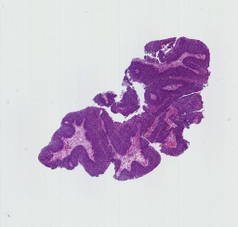

In [3]:
wsi

In [4]:
zs.pp.find_tissues(wsi)
zs.pp.tile_tissues(wsi, 512, background_fraction=0.95, mpp=0.5)

## Zero-shot classification

We will first try to do zero-shot classification with conch, a text-image model

In [5]:
zs.tl.feature_extraction(wsi, "conch")

/home/runner/work/lazyslide-tutorials/lazyslide-tutorials/.venv/lib/python3.12/site-packages/timm/models/layers/__init__.py:48: FutureWarning: Importing from timm.models.layers is deprecated, please import via timm.layers
  warnings.warn(f"Importing from {__name__} is deprecated, please import via timm.layers", FutureWarning)


meta.yaml:   0%|          | 0.00/37.0 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/802M [00:00<?, ?B/s]

Output()

We need to prepare a set of classes to predict the probability.

In [6]:
classes = ["lung carcinoma", "breast carcinoma", "normal tissue"]

In [7]:
embeds = zs.tl.text_embedding(classes, model="conch")
zs.tl.text_image_similarity(wsi, embeds, model="conch", softmax=True)

We will use top-k scoring to decide the score of each classes.

In [8]:
scores = zs.metrics.topk_score(wsi["conch_tiles_text_similarity"], agg_method="max")
for c, s in zip(classes, scores / scores.sum()):
    print(f"{c}: {s:.2f}")

lung carcinoma: 0.36
breast carcinoma: 0.32
normal tissue: 0.33


Alternatively, we can use Prism or Titan to query the probability directly.

The input of prism's slide encoder must come from virchow model

In [9]:
zs.tl.feature_extraction(wsi, "virchow")
zs.tl.feature_aggregation(wsi, feature_key="virchow", encoder="prism", device="cpu")

config.json:   0%|          | 0.00/716 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.52G [00:00<?, ?B/s]

Output()

In [10]:
zs.tl.zero_shot_score(wsi, classes, feature_key="virchow_tiles", device="cpu")

,lung carcinoma,breast carcinoma,normal tissue
0,0.912962,0.069559,0.017479


In [11]:
results = zs.tl.slide_caption(
    wsi, ["what is the diagnosis of the slide?"], feature_key="virchow_tiles", device="cpu", model="prism"
)
results['caption'][0]


['</s>what is the diagnosis of the slide? </s>In situ squamous cell carcinoma with positive p16 and high-risk HPV. </s>']